# Building the ML model for comparison

Oversampling Accuracy Testing - Error

New Core Points:
     Feature_1  Feature_2
0    -1.781196   8.157665
1    -1.840718   8.639973
2    -2.408069   9.738214
3    -3.227625   9.901787
4    -3.032536   9.191316
..         ...        ...
395  -2.257281   7.721057
396  -2.779035   9.237344
397  -1.507892   8.816357
398  -2.765161   8.649744
399  -2.443295   8.084358

[400 rows x 2 columns]
Class Distribution after Custom Oversampling:
1.0    686
0.0     61
Name: count, dtype: int64
Original Data - Accuracy: 0.76, Precision: 0.76, Recall: 1.00, F1 Score: 0.86
SMOTE Data - Accuracy: 0.40, Precision: 0.68, Recall: 0.39, F1 Score: 0.50
Custom Oversampling Data - Accuracy: 0.76, Precision: 0.76, Recall: 1.00, F1 Score: 0.86


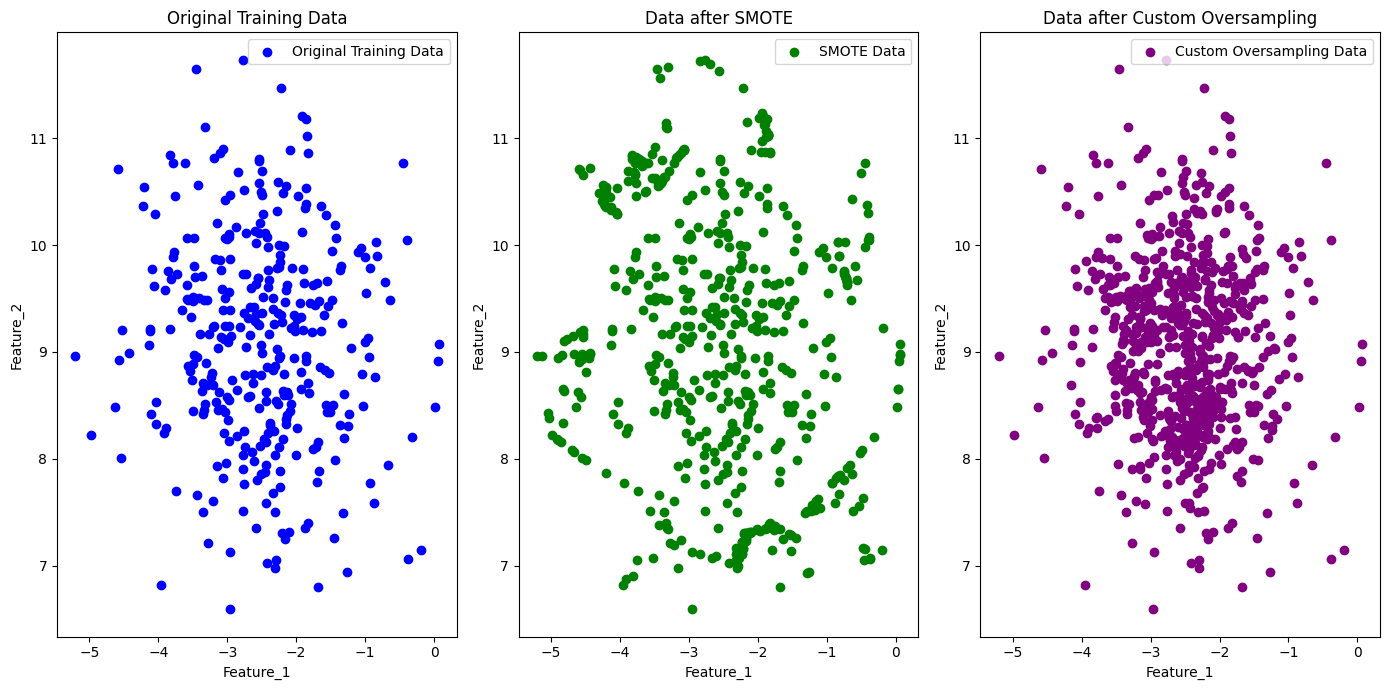

In [3]:
from sklearn.datasets import make_blobs
import pandas as pd
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import random
from scipy.stats import zscore

# DATA GENERATION
n_samples = 500
n_features = 2
n_classes = 1
X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_classes, cluster_std=1.0, random_state=42)

# DATA FRAME
feature_columns = [f'Feature_{i+1}' for i in range(n_features)]
data = pd.DataFrame(X, columns=feature_columns)
data['Class'] = y

# CLASS SELECTION
class_1_data = data[data['Class'] == 0]
class_1_data_features = class_1_data.drop(columns=['Class'])

# PAIRWISE DISTANCES
distances = pdist(class_1_data_features, metric='euclidean')
distance_matrix = squareform(distances)

# AVERAGE DISTANCES
np.fill_diagonal(distance_matrix, np.nan)
average_distances = np.nanmean(distance_matrix, axis=1)
class_1_data = class_1_data.assign(Average_Distance=average_distances)

# THRESHOLD TO CLASSIFY INTO CORE AND BOUNDARY
threshold = class_1_data['Average_Distance'].quantile(0.8)
core_instances = class_1_data[class_1_data['Average_Distance'] <= threshold]
boundary_instances = class_1_data[class_1_data['Average_Distance'] > threshold]

# LABEL CORE AND BOUNDARY
data['Core_Boundary'] = np.where(data.index.isin(core_instances.index), 1, 0)

# REMOVE OUTLIERS USING Z-SCORE
z_scores = np.abs(zscore(data[feature_columns]))
data_no_outliers = data[(z_scores < 3).all(axis=1)]

# SPLIT DATA
X = data_no_outliers[feature_columns]
y = data_no_outliers['Core_Boundary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# APPLY SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# CUSTOM OVERSAMPLING TECHNIQUE

# Update core and boundary instances based on the data without outliers
core_instances_no_outliers = core_instances[core_instances.index.isin(data_no_outliers.index)]
boundary_instances_no_outliers = boundary_instances[boundary_instances.index.isin(data_no_outliers.index)]

# PAIRWISE DISTANCES FOR CORE INSTANCES
core_features = core_instances_no_outliers.drop(columns=['Class', 'Average_Distance'])
core_distances = pdist(core_features, metric='euclidean')
core_distance_matrix = squareform(core_distances)

# PAIRWISE DISTANCES FOR BOUNDARY INSTANCES
boundary_features = boundary_instances_no_outliers.drop(columns=['Class', 'Average_Distance'])
boundary_distances = pdist(boundary_features, metric='euclidean')
boundary_distance_matrix = squareform(boundary_distances)

# AVERAGE DISTANCE BETWEEN CORE POINTS
average_core_distance = np.nanmean(core_distance_matrix)

# RADIUS
radius = average_core_distance / 2

def create_midpoint_points(data, distance_matrix, radius, core_count, boundary_count):
    new_points = []
    threshold_distance = radius  # To place core points only within this distance
    num_features = data.shape[1]  # Gets the number of features
    valid_pairs = []  # Stores matrix position points within threshold distance

    max_new_points = core_count # Determine the desired number of new core points

    if max_new_points <= 0:
        return pd.DataFrame(columns=data.columns)  # No new points needed

    for i in range(len(data)): # Collect valid pairs
        for j in range(i + 1, len(data)):
            if distance_matrix[i, j] <= threshold_distance:
                valid_pairs.append((i, j))

    random.shuffle(valid_pairs) # So points are not clustered in one area

    for idx1, idx2 in valid_pairs: # Create new points until the limit is reached
        if len(new_points) >= max_new_points:
            break
        point1 = data.iloc[idx1].values
        point2 = data.iloc[idx2].values
        midpoint = (point1 + point2) / 2
        new_points.append(midpoint)

    return pd.DataFrame(new_points, columns=data.columns)

core_count = len(core_instances_no_outliers)
boundary_count = len(boundary_instances_no_outliers)
new_core_points = create_midpoint_points(core_features, core_distance_matrix, radius, core_count, boundary_count)

# Print new core points for verification
print("New Core Points:")
print(new_core_points)

# Combine new core points with the original training data
X_train_custom = pd.concat([X_train, new_core_points])
y_train_custom = np.concatenate([y_train, np.ones(len(new_core_points))])

# Verify the class distribution after custom oversampling
print("Class Distribution after Custom Oversampling:")
print(pd.Series(y_train_custom).value_counts())

# TRAIN CLASSIFIER ON ORIGINAL DATA
classifier_original = LogisticRegression()
classifier_original.fit(X_train, y_train)

# TRAIN CLASSIFIER ON SMOTE DATA
classifier_smote = LogisticRegression()
classifier_smote.fit(X_train_smote, y_train_smote)

# TRAIN CLASSIFIER ON CUSTOM OVERSAMPLED DATA
classifier_custom = LogisticRegression()
classifier_custom.fit(X_train_custom, y_train_custom)

# MAKE PREDICTIONS
y_pred_original = classifier_original.predict(X_test)
y_pred_smote = classifier_smote.predict(X_test)
y_pred_custom = classifier_custom.predict(X_test)

# EVALUATE PERFORMANCE
accuracy_original = accuracy_score(y_test, y_pred_original)
precision_original = precision_score(y_test, y_pred_original)
recall_original = recall_score(y_test, y_pred_original)
f1_original = f1_score(y_test, y_pred_original)

accuracy_smote = accuracy_score(y_test, y_pred_smote)
precision_smote = precision_score(y_test, y_pred_smote)
recall_smote = recall_score(y_test, y_pred_smote)
f1_smote = f1_score(y_test, y_pred_smote)

accuracy_custom = accuracy_score(y_test, y_pred_custom)
precision_custom = precision_score(y_test, y_pred_custom)
recall_custom = recall_score(y_test, y_pred_custom)
f1_custom = f1_score(y_test, y_pred_custom)

print(f'Original Data - Accuracy: {accuracy_original:.2f}, Precision: {precision_original:.2f}, Recall: {recall_original:.2f}, F1 Score: {f1_original:.2f}')
print(f'SMOTE Data - Accuracy: {accuracy_smote:.2f}, Precision: {precision_smote:.2f}, Recall: {recall_smote:.2f}, F1 Score: {f1_smote:.2f}')
print(f'Custom Oversampling Data - Accuracy: {accuracy_custom:.2f}, Precision: {precision_custom:.2f}, Recall: {recall_custom:.2f}, F1 Score: {f1_custom:.2f}')

# PLOT DATA AFTER SMOTE AND CUSTOM OVERSAMPLING
plt.figure(figsize=(14, 7))

# Plot Original Training Data
plt.subplot(1, 3, 1)
plt.scatter(X_train['Feature_1'], X_train['Feature_2'], color='blue', label='Original Training Data')
plt.title('Original Training Data')
plt.xlabel('Feature_1')
plt.ylabel('Feature_2')
plt.legend()

# Plot Data after SMOTE
plt.subplot(1, 3, 2)
plt.scatter(X_train_smote['Feature_1'], X_train_smote['Feature_2'], color='green', label='SMOTE Data')
plt.title('Data after SMOTE')
plt.xlabel('Feature_1')
plt.ylabel('Feature_2')
plt.legend()

# Plot Data after Custom Oversampling
plt.subplot(1, 3, 3)
plt.scatter(X_train_custom['Feature_1'], X_train_custom['Feature_2'], color='purple', label='Custom Oversampling Data')
plt.title('Data after Custom Oversampling')
plt.xlabel('Feature_1')
plt.ylabel('Feature_2')
plt.legend()

plt.tight_layout()
plt.show()
